### RNN with TensorFlow
- [Code Link](https://towardsdatascience.com/tensorflow-keras-cheat-sheet-5ec99d9a1ccf)

In [98]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# special imports for CV and NLP
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

print('##########  Library Versions  ##########')
print(f' Numpy Version: {np.__version__}')
print(f' Pandas Version: {pd.__version__}')
print(f' Keras Version: {keras.__version__}')
print(f' TensorFlow Version: {tf.__version__}')
print(f' Seaborn Version: {sns.__version__}')

##########  Library Versions  ##########
 Numpy Version: 1.21.4
 Pandas Version: 1.4.0
 Keras Version: 2.8.0
 TensorFlow Version: 2.8.0
 Seaborn Version: 0.11.2


In [99]:
# Constaints:

NUM_EPOCHS = 2
BATCH_SIZE = 32

In [122]:
df = pd.read_csv(r'C:\Data Sciences\Data\all_data_files\bbc-text.csv')

sentences = df['text'].to_numpy()
labels = df['category']
dataset_size = len(sentences)
training_size = int(len(sentences) * 0.8)

training_sentences = sentences[:training_size]
training_labels_text = labels[:training_size]
validation_sentences = sentences[training_size:]
validation_labels_text = labels[training_size:]

label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(training_labels_text)

training_labels = np.array(label_tokenizer.texts_to_sequences(training_labels_text))
validation_labels = np.array(label_tokenizer.texts_to_sequences(validation_labels_text))

num_classes_nlp = len(np.unique(training_labels))

print('BBC news dataset dowloaded from https://www.kaggle.com/yufengdev/bbc-fulltext-and-category')
print(f'Dataset size: {dataset_size}')
print(f'Train set size: {len(training_sentences)}')
print(f'Validation set size: {len(validation_sentences)}')
print('')
#print(f'First training sentence: {training_sentences[3]}')
#print(f'First training label: {training_labels[3]}')

# default parameters
vocab_size = 2000
embedding_dim = 32
max_length = 125
trunc_type = "post"
padding_type = "post"
oov_tok = "<OOV>"

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences,
                                maxlen=max_length,
                                padding=padding_type,
                                truncating=trunc_type)

validation_sequences = tokenizer.texts_to_sequences(validation_sentences)
validation_padded = pad_sequences(validation_sequences,
                                  maxlen=max_length,
                                  padding=padding_type)


BBC news dataset dowloaded from https://www.kaggle.com/yufengdev/bbc-fulltext-and-category
Dataset size: 2225
Train set size: 1780
Validation set size: 445



In [123]:
#token_lens = []

#for txt in sentences:
#  tokens = tokenizer.encode(txt, max_length=512)
#  token_lens.append(len(tokens))

#sns.distplot(token_lens)
#plt.title('Token Count Distribution')
#plt.xlim([0, 512]);
#plt.xlabel('Token count')

In [125]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    filepath='model_callback.h5',
    save_weights_only=True,
    monitor='val_loss',  # 'val_accuracy'
    mode='min',  # 'max'
    save_best_only=True,
    verbose=1)

earlystop_cb = tf.keras.callbacks.EarlyStopping(
    monitor='loss',
    patience=5,
    verbose=1)

callbacks = [earlystop_cb, checkpoint_cb]

# RNN for NLP
model = tf.keras.Sequential([
    layers.Embedding(vocab_size,
                     embedding_dim,
                     input_length=max_length),
    layers.Bidirectional(layers.LSTM(32, return_sequences=True)),
    layers.Bidirectional(layers.LSTM(16)),
    layers.Dropout(0.5),
    layers.Dense(16, activation='relu'),
    layers.Dense(6, activation='softmax')  # multiclass classification
])

model.summary()

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(
    training_padded,
    training_labels,
    epochs=NUM_EPOCHS,
    shuffle = True,
    callbacks = callbacks,
    workers = 10,
    use_multiprocessing = True,
    validation_data=(validation_padded, validation_labels),
    verbose=1)

print('')
print('###########  Validation Metrics  ##########')
model.evaluate(validation_padded, validation_labels)

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_18 (Embedding)    (None, 125, 32)           64000     
                                                                 
 bidirectional_36 (Bidirecti  (None, 125, 64)          16640     
 onal)                                                           
                                                                 
 bidirectional_37 (Bidirecti  (None, 32)               10368     
 onal)                                                           
                                                                 
 dropout_18 (Dropout)        (None, 32)                0         
                                                                 
 dense_36 (Dense)            (None, 16)                528       
                                                                 
 dense_37 (Dense)            (None, 6)               

TypeError: Invalid keyword argument(s) in `compile()`: ({'learning_rate'},). Valid keyword arguments include "cloning", "experimental_run_tf_function", "distribute", "target_tensors", or "sample_weight_mode".

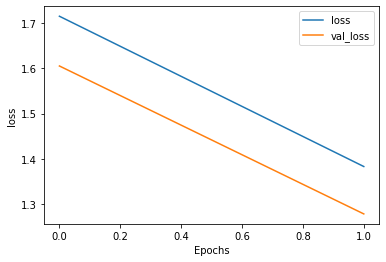

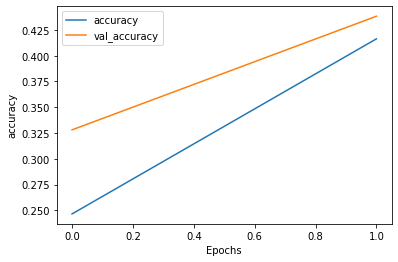

In [89]:
def plot_learning_curves(history, parameter):
    """ 
    Plot learning curves from 'history' object.

    Parameters:
        history (History object): result of the `fit` method execution
        parameter (str): parameter to explore: 'accuracy', 'loss', etc.

    >>> history = model.fit(...)
    >>> plot_learning_curves(history, "loss")
    >>> plot_learning_curves(history, "accuracy")
    >>> plot_learning_curves(history, "mse")
    """

    plt.plot(history.history[parameter])
    plt.plot(history.history['val_'+parameter])
    plt.xlabel("Epochs")
    plt.ylabel(parameter)
    plt.legend([parameter, 'val_'+parameter])
    plt.show()


plot_learning_curves(history, "loss")
plot_learning_curves(history, "accuracy")

In [83]:
tf.keras.utils.plot_model(model)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
